# Imports 

In [1]:
from datetime import datetime
import numpy as np
import os
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels
import scipy as sp
import pickle

In [2]:
!pip install cdsapi

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


#Download Data via Copernicus API

In [ ]:
url = 'url: https://cds.climate.copernicus.eu/api/v2'
key = 'key: 59923:dc18e3f9-2ffd-444b-83aa-eecaeac9212a'

with open('/root/.cdsapirc', 'w') as f:
    f.write('\n'.join([url, key]))

with open('/root/.cdsapirc') as f:
    print(f.read())

url: https://cds.climate.copernicus.eu/api/v2
key: 59923:dc18e3f9-2ffd-444b-83aa-eecaeac9212a


In [ ]:
import cdsapi

c = cdsapi.Client()

c.retrieve(
    'reanalysis-era5-pressure-levels',
    {
        'product_type': 'reanalysis',
        'variable': [
            'geopotential', 'relative_humidity', 'specific_rain_water_content',
            'specific_snow_water_content', 'temperature',
        ],
        'pressure_level': [
            '1', '2', '3',
            '5', '7', '10',
            '20', '30', '50',
            '70', '100', '125',
            '150', '175', '200',
            '225', '250', '300',
            '350', '400', '450',
            '500', '550', '600',
            '650', '700', '750',
            '775', '800', '825',
            '850', '875', '900',
            '925', '950', '975',
            '1000',
        ],
        'year': '2019',
        'month': [
            '01', '02', '03',
            '04', '05', '06',
            '07', '08', '09',
            '10', '11', '12',
        ],
        'day': [
            '08', '15', '22',
            '29',
        ],
        'time': [
            '00:00',
        ],
        'area': [
            85, -170, 40,
            -50,
        ],
        'format': 'netcdf',
    },
    '/content/drive/My Drive/era5_4days.nc')

2020-10-27 16:35:13,813 INFO Welcome to the CDS
2020-10-27 16:35:13,814 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-10-27 16:35:14,513 INFO Request is queued


KeyboardInterrupt: ignored

# Load Data

In [4]:
path = "/content/drive/My Drive"
file = os.path.join(path, "era5_2yrs.nc")

In [5]:
DS = xr.open_dataset(file)

In [6]:
DS

<xarray.Dataset>
Dimensions:    (latitude: 181, level: 37, longitude: 481, time: 24)
Coordinates:
  * longitude  (longitude) float32 -170.0 -169.75 -169.5 ... -50.5 -50.25 -50.0
  * latitude   (latitude) float32 85.0 84.75 84.5 84.25 ... 40.5 40.25 40.0
  * level      (level) int32 1 2 3 5 7 10 20 30 ... 850 875 900 925 950 975 1000
  * time       (time) datetime64[ns] 2018-01-15 2018-02-15 ... 2019-12-15
Data variables:
    z          (time, level, latitude, longitude) float32 ...
    r          (time, level, latitude, longitude) float32 ...
    crwc       (time, level, latitude, longitude) float32 ...
    cswc       (time, level, latitude, longitude) float32 ...
    t          (time, level, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2020-10-27 20:47:35 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...

In [7]:
# Convert XArray to dataframe
ds = DS.to_dataframe()

In [8]:
ds

z  ...           t
latitude level longitude time                       ...            
85.0     1     -170.0    2018-01-15  426127.000000  ...  243.416428
                         2018-02-15  471957.218750  ...  245.021347
                         2018-03-15  447069.093750  ...  237.073944
                         2018-04-15  459232.937500  ...  256.905884
                         2018-05-15  477895.218750  ...  279.941528
...                                            ...  ...         ...
40.0     1000  -50.0     2019-08-15    1673.125000  ...  297.607849
                         2019-09-15    1135.375000  ...  289.534485
                         2019-10-15    1536.796875  ...  291.052063
                         2019-11-15    2173.015625  ...  285.235748
                         2019-12-15    2741.062500  ...  285.615631

[77310168 rows x 5 columns]

# Data preprocessing

In [9]:
ds.reset_index(inplace=True)
ds['time'] = pd.to_datetime(ds['time'])

In [10]:
ds

latitude  level  longitude  ...          crwc          cswc           t
0             85.0      1     -170.0  ...  0.000000e+00 -1.164153e-10  243.416428
1             85.0      1     -170.0  ...  0.000000e+00 -1.164153e-10  245.021347
2             85.0      1     -170.0  ...  0.000000e+00 -1.164153e-10  237.073944
3             85.0      1     -170.0  ...  0.000000e+00 -1.164153e-10  256.905884
4             85.0      1     -170.0  ...  0.000000e+00 -1.164153e-10  279.941528
...            ...    ...        ...  ...           ...           ...         ...
77310163      40.0   1000      -50.0  ...  3.401772e-06 -1.164153e-10  297.607849
77310164      40.0   1000      -50.0  ...  1.952084e-05 -1.164153e-10  289.534485
77310165      40.0   1000      -50.0  ...  2.616434e-08 -1.164153e-10  291.052063
77310166      40.0   1000      -50.0  ...  1.150055e-05 -1.164153e-10  285.235748
77310167      40.0   1000      -50.0  ...  0.000000e+00 -1.164153e-10  285.615631

[77310168 rows x 9 columns]

In [13]:
# Load in locations/dates of relevant vertical profiles
locs = pd.read_csv('/content/drive/My Drive/era5_loc_2yrs.csv') 

In [14]:
locs.rename(columns={'i': 'latitude', 'j':'longitude'}, inplace=True)
locs['time'] = pd.to_datetime(locs['time'])

In [15]:
locs.drop_duplicates()

latitude  longitude       time
0            83.0     -74.50 2018-06-15
1            83.0     -74.50 2018-08-15
2            83.0     -74.50 2018-09-15
3            83.0     -74.50 2019-05-15
4            83.0     -74.50 2019-06-15
...           ...        ...        ...
1606711      40.0     -94.50 2019-02-15
1607102      40.0     -89.25 2018-01-15
1607183      40.0     -87.75 2018-03-15
1607875      40.0     -75.00 2018-01-15
1607893      40.0     -74.75 2018-01-15

[294519 rows x 3 columns]

In [16]:
# Only take observations that have corresponding skin temperatures of -5 to 5 degrees
merged_ds = pd.merge(ds, locs, on=['longitude', 'latitude', 'time'])
merged_ds.drop_duplicates(inplace=True)
merged_ds

latitude  level  longitude  ... crwc          cswc           t
0             83.0      1      -80.0  ...  0.0 -1.164153e-10  284.205750
2             83.0      2      -80.0  ...  0.0 -1.164153e-10  277.806396
4             83.0      3      -80.0  ...  0.0 -1.164153e-10  269.901642
6             83.0      5      -80.0  ...  0.0 -1.164153e-10  254.805252
8             83.0      7      -80.0  ...  0.0 -1.164153e-10  247.983337
...            ...    ...        ...  ...  ...           ...         ...
59493807      40.0    900      -74.0  ...  0.0 -1.164153e-10  274.687958
59493809      40.0    925      -74.0  ...  0.0 -1.164153e-10  274.659515
59493811      40.0    950      -74.0  ...  0.0 -1.164153e-10  275.833771
59493813      40.0    975      -74.0  ...  0.0 -1.164153e-10  277.402100
59493815      40.0   1000      -74.0  ...  0.0 -1.164153e-10  279.153290

[10897203 rows x 9 columns]

In [17]:
ii = merged_ds.sort_values(by = ['latitude', 'longitude', 'time', 'level']).groupby(['latitude', 'longitude', 'time'])

In [18]:
# List to store vertical profiles of interest
dfs = []
for name, group in ii:
  group['t'] = group['t'].map(lambda x: x - 273.15)
  group['snow_frac'] = group.apply(lambda row: row['cswc']/(row['crwc'] + row['cswc']), axis=1)
  dfs.append(group)

In [19]:
len(dfs)

294519

In [20]:
final_ds = pd.concat(dfs)

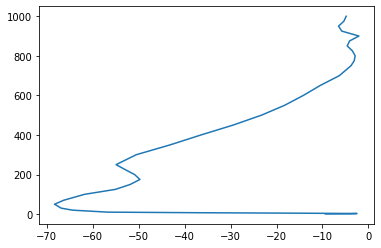

In [21]:
# Plot vertical profiles
i = 1000
plt.plot(dfs[i]['t'], dfs[i]['level'] )

In [22]:
# Fix invalid snow fraction values
final_ds['snow_frac'] = final_ds['snow_frac'].map(lambda x: 0 if x < 0 else x) 
final_ds['snow_frac'] = final_ds['snow_frac'].map(lambda x: 1 if x > 1 else x) 

In [23]:
final_ds = final_ds[final_ds['level'] == 1000]

In [24]:
final_ds.set_index(['latitude', 'longitude', 'time'], inplace=True)
final_ds

level            z  ...         t  snow_frac
latitude longitude time                            ...                     
40.0     -123.75   2019-02-15   1000     6.843750  ...  8.498041        0.0
                   2019-12-15   1000  1347.453125  ...  7.459924        0.0
         -123.50   2019-02-15   1000    59.875000  ...  7.888574        0.0
                   2019-12-15   1000  1392.890625  ...  6.696069        0.0
         -123.25   2018-03-15   1000  1218.687500  ...  9.166406        0.0
...                              ...          ...  ...       ...        ...
83.0     -66.50    2018-06-15   1000  1514.078125  ... -0.343237        1.0
                   2018-07-15   1000    90.156250  ...  6.629022        1.0
                   2018-08-15   1000   317.390625  ...  1.119470        0.0
                   2019-06-15   1000  1536.796875  ...  1.464838        0.0
                   2019-08-15   1000  1445.906250  ...  2.393243        0.0

[294519 rows x 7 columns]

In [25]:
# Check that every level has the same number of samples
final_ds['level'].value_counts()

1000    294519
Name: level, dtype: int64

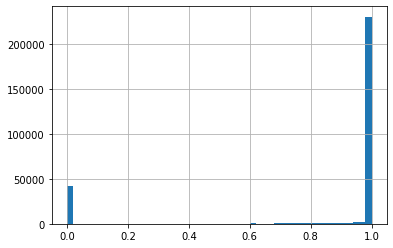

In [26]:
final_ds['snow_frac'].hist(bins=50)

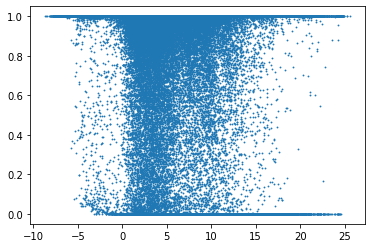

In [27]:
plt.scatter(final_ds.t, final_ds.snow_frac, s=0.7)

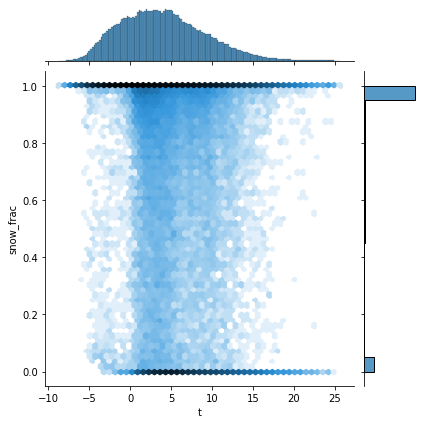

In [28]:
sns.jointplot(x=final_ds['t'], y=final_ds['snow_frac'], kind='hex', bins='log') 

# Isotonic Regression

In [29]:
 from sklearn.isotonic import IsotonicRegression

In [30]:
x = final_ds['t']
y = final_ds['snow_frac']
xx = np.linspace(x.min(), x.max(), 1000) # for graphing

ir = IsotonicRegression(increasing=False).fit(x, y)

# Actual predictions
y_pred = ir.predict(x)

# For graphing
yy_pred = ir.predict(xx)

Text(0, 0.5, 'Snow Fraction')

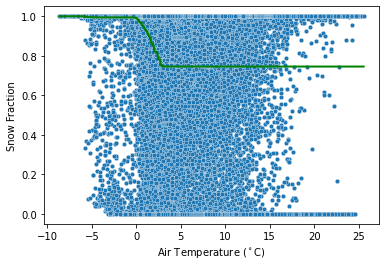

In [31]:
plt.scatter(x, y, marker='o', edgecolor='white', linewidth=0.3, label='Original', s=20)
plt.plot(xx, yy_pred, color='green', label= 'Isotonic', linewidth=2)
plt.xlabel('Air Temperature ($^\circ$C)')
plt.ylabel('Snow Fraction')

# Classification Functions

In [32]:
from sklearn.metrics import balanced_accuracy_score, classification_report, confusion_matrix

def cm_plot(y_true, y_pred, classes, cm_fig_path=None,
                normalize=False,
                title=None,
                cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred, normalize=normalize)
    
    samples = np.array(y_true).shape[0]
    accuracy = np.trace(cm) / float(np.sum(cm)) * 100
    
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            # print('for i {} and j {} : {}'.format(i, j, cm[i,j]))
            ax.annotate(format(cm[i, j], fmt), (j, i),
            ha="center", va="center",
            color="white" if cm[i, j] > thresh else "black")
    np.set_printoptions(precision=2)
#     plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('\nPredicted label\naccuracy={:0.2f}%; N={}'.format(accuracy, samples))
    plt.ylim([2.5, -.5])
    plt.tight_layout()
    if cm_fig_path is not None:
        plt.savefig(cm_fig_path)
    plt.show()
    plt.close('all')


In [33]:
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder, PowerTransformer

def Standardize(X, y, method="robust"):
    if method == "robust":
        X_norm = RobustScaler().fit_transform(np.array(X))
    elif method == "standard":
        X_norm = StandardScaler().fit_transform(np.array(X))
    elif method == "power":
        X_norm = PowerTransformer().fit_transform(np.array(X))
    elif method == "none":
        X_norm = X
    y_encoded = LabelEncoder().fit_transform(y)
    return X_norm, y_encoded

In [34]:
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier

def Train_and_Evaluate_Classifier(X, y_encoded, y, classifier='sgd', normalize=None, kernel='linear', ccp_alpha=0.015, max_depth=30, min_samples_leaf=0.05, min_samples_split=0.05):
    if classifier == 'sgd':
        clf = SGDClassifier(class_weight="balanced", loss='perceptron', penalty='l1')
        title = "SGD Classifier"
    elif classifier == 'svm':
        if kernel == 'linear':
            clf = LinearSVC(dual=False, class_weight='balanced', penalty='l1')
            title = "LinearSVM Classifier"
        else:
            clf = SVC(kernel=kernel, class_weight='balanced', cache_size=4*1024)
            title = str(kernel + " SVM Classifier")
    elif classifier == 'nb':
        clf = GaussianNB()
#         clf.partial_fit(X, y_encoded, classes=np.unique(y_encoded))
        title = "Naive Bayes Classifier"
    elif classifier == 'gp':
        clf = GaussianProcessClassifier(copy_X_train=False)
        title = 'Gaussian Process Classifier'
    elif classifier == "decision_tree":
        clf = DecisionTreeClassifier(
            class_weight='balanced', 
            ccp_alpha=ccp_alpha, 
            min_samples_leaf=min_samples_leaf,
            max_depth=max_depth, 
            min_samples_split=min_samples_split
        )
        title = "Decision Tree Classifier"
    elif classifier == "random_forest":
        clf = RandomForestClassifier(
            n_jobs=-1, 
            class_weight="balanced_subsample",
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            ccp_alpha=ccp_alpha
        )
        title = "Random Forest Classifier"
    clf.fit(X, y_encoded)
    y_pred = clf.predict(X)           
    pred = [round(value) for value in y_pred]
    print("Classifier Accuracy %.2f%%" % (balanced_accuracy_score(y_encoded, pred) * 100.0))
    print('------------------------------------------------------------------------')
    print(classification_report(y_encoded, pred, target_names=list(np.unique(y))))
    cm_plot(y_encoded, y_pred, list(np.unique(y)), normalize=normalize, cm_fig_path='cm.png', title=title)
    return clf, y_pred

In [35]:
def Precip_Type(x, lower_thresh=0.05, upper_thresh=0.95):
    if x <= lower_thresh:
        return "Rain"
    elif x > lower_thresh and x <= upper_thresh:
        return "Mixed"
    else:
        return "Snow"

# Classification

In [36]:
final_ds['precip_type'] = final_ds['snow_frac'].map(Precip_Type)
final_ds

level            z  ...  snow_frac  precip_type
latitude longitude time                            ...                        
40.0     -123.75   2019-02-15   1000     6.843750  ...        0.0         Rain
                   2019-12-15   1000  1347.453125  ...        0.0         Rain
         -123.50   2019-02-15   1000    59.875000  ...        0.0         Rain
                   2019-12-15   1000  1392.890625  ...        0.0         Rain
         -123.25   2018-03-15   1000  1218.687500  ...        0.0         Rain
...                              ...          ...  ...        ...          ...
83.0     -66.50    2018-06-15   1000  1514.078125  ...        1.0         Snow
                   2018-07-15   1000    90.156250  ...        1.0         Snow
                   2018-08-15   1000   317.390625  ...        0.0         Rain
                   2019-06-15   1000  1536.796875  ...        0.0         Rain
                   2019-08-15   1000  1445.906250  ...        0.0         Rain

[294519 rows x 8 columns]

In [37]:
final_ds['precip_type'].value_counts()

Snow     234230
Rain      43107
Mixed     17182
Name: precip_type, dtype: int64

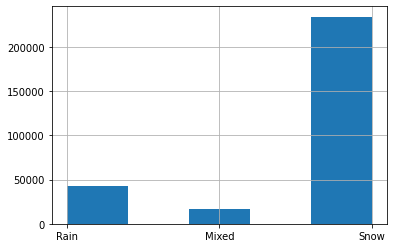

In [38]:
final_ds['precip_type'].hist(bins=5)

Class imbalance needs to be addressed

In [39]:
y = final_ds['precip_type']
X = np.array(final_ds['t']).reshape(-1, 1)

In [40]:
encodings = {"Rain": 1, "Mixed": 0, "Snow": 2}

In [41]:
rain_ds = final_ds[final_ds['precip_type'] == 'Rain'].reset_index()
snow_ds = final_ds[final_ds['precip_type'] == 'Snow'].reset_index()
mixed_ds = final_ds[final_ds['precip_type'] == 'Mixed'].reset_index()

In [42]:
X_norm_pow, y_encoded = Standardize(X, y, method='power')
X_norm_robust, y_encoded = Standardize(X, y, method='robust')
X_norm_std, y_encoded = Standardize(X, y, method='standard')
X_norm, y_encoded = Standardize(X, y, method='none')

#### SVM

Classifier Accuracy 33.67%
------------------------------------------------------------------------


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       Mixed       0.00      0.00      0.00     17182
        Rain       0.16      0.09      0.12     43107
        Snow       0.80      0.92      0.85    234230

    accuracy                           0.74    294519
   macro avg       0.32      0.34      0.32    294519
weighted avg       0.66      0.74      0.70    294519



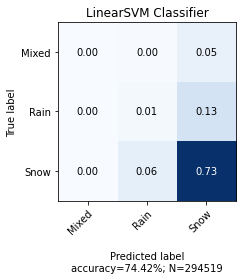

In [43]:
linsvm, linsvm_pred = Train_and_Evaluate_Classifier(X_norm_pow, y_encoded, y, classifier='svm', normalize='all', kernel='linear') 

Classifier Accuracy 33.65%
------------------------------------------------------------------------


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       Mixed       0.00      0.00      0.00     17182
        Rain       0.16      0.08      0.11     43107
        Snow       0.80      0.92      0.86    234230

    accuracy                           0.75    294519
   macro avg       0.32      0.34      0.32    294519
weighted avg       0.66      0.75      0.70    294519



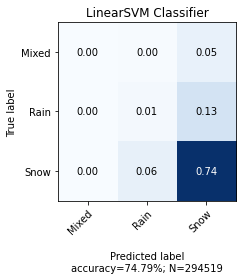

(LinearSVC(C=1.0, class_weight='balanced', dual=False, fit_intercept=True,
           intercept_scaling=1, loss='squared_hinge', max_iter=1000,
           multi_class='ovr', penalty='l1', random_state=None, tol=0.0001,
           verbose=0), array([2, 2, 2, ..., 2, 2, 2]))

In [44]:
Train_and_Evaluate_Classifier(X_norm_std, y_encoded, y, classifier='svm', normalize='all', kernel='linear') 

Classifier Accuracy 33.65%
------------------------------------------------------------------------


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       Mixed       0.00      0.00      0.00     17182
        Rain       0.16      0.08      0.11     43107
        Snow       0.80      0.92      0.86    234230

    accuracy                           0.75    294519
   macro avg       0.32      0.34      0.32    294519
weighted avg       0.66      0.75      0.70    294519



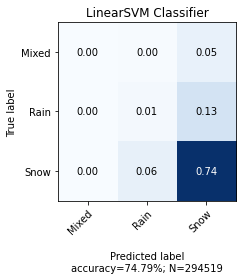

(LinearSVC(C=1.0, class_weight='balanced', dual=False, fit_intercept=True,
           intercept_scaling=1, loss='squared_hinge', max_iter=1000,
           multi_class='ovr', penalty='l1', random_state=None, tol=0.0001,
           verbose=0), array([2, 2, 2, ..., 2, 2, 2]))

In [45]:
Train_and_Evaluate_Classifier(X_norm_robust, y_encoded, y, classifier='svm', normalize='all', kernel='linear') 

Classifier Accuracy 33.65%
------------------------------------------------------------------------


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       Mixed       0.00      0.00      0.00     17182
        Rain       0.16      0.08      0.11     43107
        Snow       0.80      0.92      0.86    234230

    accuracy                           0.75    294519
   macro avg       0.32      0.34      0.32    294519
weighted avg       0.66      0.75      0.70    294519



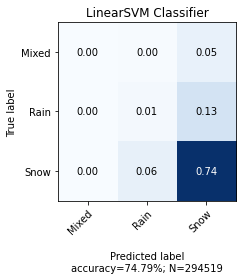

(LinearSVC(C=1.0, class_weight='balanced', dual=False, fit_intercept=True,
           intercept_scaling=1, loss='squared_hinge', max_iter=1000,
           multi_class='ovr', penalty='l1', random_state=None, tol=0.0001,
           verbose=0), array([2, 2, 2, ..., 2, 2, 2]))

In [46]:
Train_and_Evaluate_Classifier(X_norm, y_encoded, y, classifier='svm', normalize='all', kernel='linear') 

## Using other Variables

In [48]:
final_ds

level            z  ...  snow_frac  precip_type
latitude longitude time                            ...                        
40.0     -123.75   2019-02-15   1000     6.843750  ...        0.0         Rain
                   2019-12-15   1000  1347.453125  ...        0.0         Rain
         -123.50   2019-02-15   1000    59.875000  ...        0.0         Rain
                   2019-12-15   1000  1392.890625  ...        0.0         Rain
         -123.25   2018-03-15   1000  1218.687500  ...        0.0         Rain
...                              ...          ...  ...        ...          ...
83.0     -66.50    2018-06-15   1000  1514.078125  ...        1.0         Snow
                   2018-07-15   1000    90.156250  ...        1.0         Snow
                   2018-08-15   1000   317.390625  ...        0.0         Rain
                   2019-06-15   1000  1536.796875  ...        0.0         Rain
                   2019-08-15   1000  1445.906250  ...        0.0         Rain

[294519 rows x 8 columns]

In [49]:
X_alt = final_ds[['z', 'r', 't']]

In [54]:
X_alt['z'] = X_alt['z'].map(lambda x: x/9.80665)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [55]:
X_norm_pow_alt, y_encoded = Standardize(X_alt, y, method='power')
X_norm_robust_alt, y_encoded = Standardize(X_alt, y, method='robust')
X_norm_std_alt, y_encoded = Standardize(X_alt, y, method='standard')
X_norm_alt, y_encoded = Standardize(X_alt, y, method='none')

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


Classifier Accuracy 49.14%
------------------------------------------------------------------------
              precision    recall  f1-score   support

       Mixed       0.08      0.18      0.11     17182
        Rain       0.37      0.56      0.45     43107
        Snow       0.91      0.74      0.81    234230

    accuracy                           0.68    294519
   macro avg       0.45      0.49      0.46    294519
weighted avg       0.78      0.68      0.72    294519



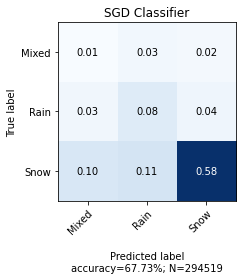

(SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
               early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
               l1_ratio=0.15, learning_rate='optimal', loss='perceptron',
               max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l1',
               power_t=0.5, random_state=None, shuffle=True, tol=0.001,
               validation_fraction=0.1, verbose=0, warm_start=False),
 array([1, 1, 1, ..., 0, 1, 0]))

In [59]:
Train_and_Evaluate_Classifier(X_norm_alt, y_encoded, y, normalize='all') 

Classifier Accuracy 46.41%
------------------------------------------------------------------------
              precision    recall  f1-score   support

       Mixed       0.03      0.00      0.00     17182
        Rain       0.39      0.51      0.44     43107
        Snow       0.87      0.88      0.88    234230

    accuracy                           0.78    294519
   macro avg       0.43      0.46      0.44    294519
weighted avg       0.75      0.78      0.76    294519



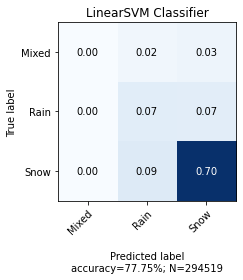

In [52]:
linsvm, linsvm_pred = Train_and_Evaluate_Classifier(X_norm_robust_alt, y_encoded, y, classifier='svm', normalize='all', kernel='linear') 

Classifier Accuracy 57.68%
------------------------------------------------------------------------
              precision    recall  f1-score   support

       Mixed       0.12      0.33      0.18     17182
        Rain       0.38      0.72      0.50     43107
        Snow       0.95      0.68      0.79    234230

    accuracy                           0.66    294519
   macro avg       0.49      0.58      0.49    294519
weighted avg       0.82      0.66      0.71    294519



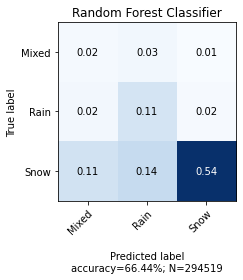

In [64]:
 rf, rf_pred = Train_and_Evaluate_Classifier(
    X_norm_pow_alt, 
    y_encoded, 
    y, 
    classifier='random_forest', 
    normalize='all',
    ccp_alpha=1e-6,
    min_samples_leaf=1,
    max_depth=10
)